# Notebook Description
This notebook computes the drift velocity, the number of cathode alpha events and related quantities for one/multiple input alpha run(s). These quantities are computed using a sample of inclusive alpha candidates. The inclusive selection is used here because the drift velocity computation relies on cathode events, which are outside the fiducial volume. The inclusive alpha event selection simply requires one and only one alpha-like S1 peak per event, and one and only one alpha-like S2 peak per event. The alpha-like conditions for the peaks are set based on the charge, time width and start time of the peaks.

# Notebook Configuration

In [1]:
# General configuration
runNumber = 4517
numPMTs = 11

# Configuration for inclusive alpha selection
minNumAllS1s = 1
maxNumAllS1s = 1

minNumAllS2s = 1
maxNumAllS2s = 5

minNumSelectedS1s = 1
maxNumSelectedS1s = 1

minNumSelectedS2s = 1
maxNumSelectedS2s = 1

minS1Charge =  60 # PEs/PMT
maxS1Charge =  1.e6 # PEs/PMT

minS2Charge =  200 # PEs/PMT
maxS2Charge =  1.e6 # PEs/PMT

minS1Width = 0.15 # us
maxS1Width = 1 # us

minS2Width =  3 # us
maxS2Width = 25 # us

minS1StartTime =   0 # us
maxS1StartTime = 649 # us

minS2StartTime = 649 # us
maxS2StartTime = 655 # us

# Configuration for cmputing drift velocity and related cathode alpha quantities
minDriftTime = 535 # us
maxDriftTime = 565 # us

# Python Imports and Plotting Options

In [2]:
import os
import functools
import time
from collections import namedtuple


import numpy             as np
import tables            as tb
import pandas            as pd
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .dst_io         as dstio
import invisible_cities.reco.corrections    as corrf

# import invisible_cities.icaro.hst_functions as hst
# Import JAH's improved hst functions for now, to allow for statistics boxes in histograms.
# Idea is that something like this will be imported in invisible_cities in the future.
import myhst_functions as hst

# Import alpha selection functions
import AlphaSelectionFunctions as asf

print("Running on:", time.asctime())

Running on: Fri Jan 12 12:23:31 2018


In [3]:
plt.style.available
#plt.style.use('seaborn-white')
plt.style.use('seaborn-talk')

optStat = True

# IPython Magic Commands 

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# KDST Data Reading and Basic Conversions

In [5]:
inputFolder   = "/Users/sorel/next/NEXTNEW/data/analysis/{0}/hdf5/dst/".format(runNumber)
inputFilename = inputFolder+"kdst_{0}_icdev_20171017_3_alpha.h5".format(runNumber)


data = dstf.load_dst(inputFilename, "DST", "Events")
data.S1e = data.S1e/numPMTs # convert to PEs/PMT
data.S1w = data.S1w/1.e3 # convert to microseconds
data.S1t = data.S1t/1.e3 # convert to microseconds
data.S1t = data.S1t - data.S1w/2 # convert to peak start time, assuming symmetric peak

data.S2e = data.S2e/numPMTs # convert to PEs/PMT
data.S2w = data.S2w # already microseconds
data.S2t = data.S2t/1.e3 # convert to microseconds
data.S2t = data.S2t - data.S2w/2 # convert to peak start time, assuming symmetric peak

# Print KDST data format
print('KDST columns:',data.columns.values)

KDST columns: ['event' 'time' 'peak' 'nS2' 'S1w' 'S1h' 'S1e' 'S1t' 'S2w' 'S2h' 'S2e'
 'S2q' 'S2t' 'Nsipm' 'DT' 'Z' 'X' 'Y' 'R' 'Phi' 'Xrms' 'Yrms']


In [6]:
# Print KDST entries and events statistics 
events = data.event
print('Number of KDST entries:', len(events))
print('Number of events: ',      len(events.unique()))

Number of KDST entries: 187130
Number of events:  186130


# Inclusive Alpha Selection

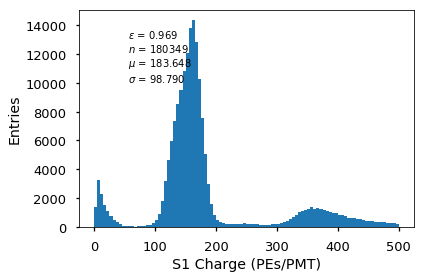

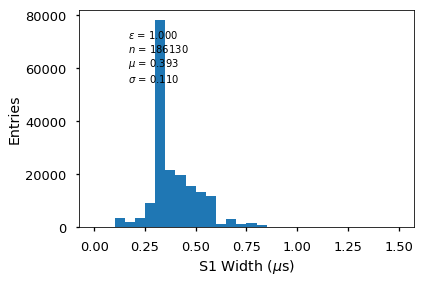

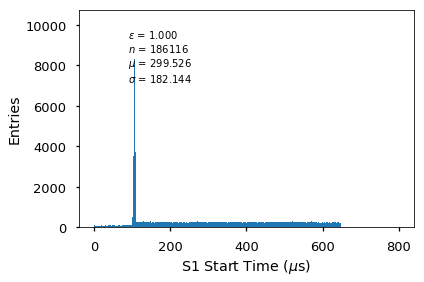

In [7]:
# Histograms of S1 charge, time width and start time. One entry per S1. Since only events with single S1s per events are in the KDST, one entry per S1 means one entry per event.
# Trick: in events with multiple S2s, the S1 information is repeated across multiple KDST entries. Fill the histogram just once for those events by selecting the first S2 peak only.
selFirstS2 = data.peak == 0
hst.hist(data[selFirstS2].S1e, 100, (0, 500.0), stats=optStat, xylabels=('S1 Charge (PEs/PMT)',    'Entries'));
hst.hist(data[selFirstS2].S1w,  30, (0,   1.5), stats=optStat, xylabels=('S1 Width ($\mu$s)',      'Entries'));
hst.hist(data[selFirstS2].S1t, 800, (0, 800.0), stats=optStat, xylabels=('S1 Start Time ($\mu$s)', 'Entries'));
# TODO: superimpose vertical lines showing cut values

In [8]:
# Alpha-like S1 selection 
selS1, inputEntries, outputEntries = asf.s1Filter(
    data,
    minS1Charge,    maxS1Charge,
    minS1Width,     maxS1Width,
    minS1StartTime, maxS1StartTime)

print('Alpha-like S1 selection:', outputEntries, '/', inputEntries, 'entries')

Alpha-like S1 selection: 175316 / 187130 entries


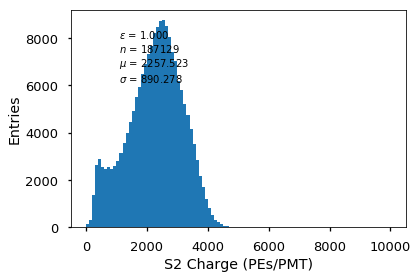

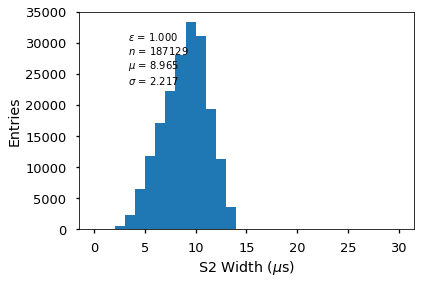

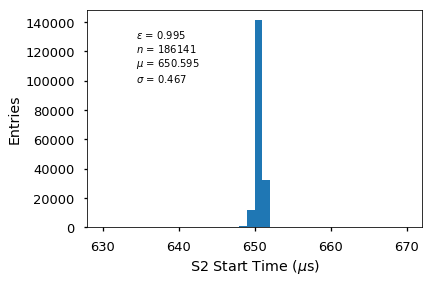

In [9]:
# Histograms of S2 charge, time width and start time. One entry per S2. Multiple S2s per event are allowed, hence the number of entries generally exceeds the number of events.
hst.hist(data.S2e, 100, (  0, 10000), stats=optStat, xylabels=('S2 Charge (PEs/PMT)',    'Entries'));
hst.hist(data.S2w,  30, (  0,    30), stats=optStat, xylabels=('S2 Width ($\mu$s)',      'Entries'));
hst.hist(data.S2t,  40, (630,   670), stats=optStat, xylabels=('S2 Start Time ($\mu$s)', 'Entries'));
# TODO: superimpose vertical lines showing cut values

In [10]:
# Alpha-like S2 selection
selS2, inputEntries, outputEntries = asf.s2Filter(
    data,
    minS2Charge,    maxS2Charge,
    minS2Width,     maxS2Width,
    minS2StartTime, maxS2StartTime)

print('Alpha-like S2 selection:', outputEntries, '/', inputEntries, 'entries')

Alpha-like S2 selection: 185141 / 187130 entries


In [11]:
# Inclusive alpha selection
# Goal: keep events with one and only one alpha-like S1, and one and only one alpha-like S2
selInclusiveAlphas, inputEntries, outputEntries = asf.inclusiveAlphaFilter(
    data, 
    minS1Charge,    maxS1Charge,
    minS1Width,     maxS1Width,
    minS1StartTime, maxS1StartTime,
    minS2Charge,    maxS2Charge,
    minS2Width,     maxS2Width,
    minS2StartTime, maxS2StartTime)

print('Inclusive alpha selection:', outputEntries, '/', inputEntries, 'entries')

# From now on, work with data frame reduced according to inclusive alpha selection
data = data[selInclusiveAlphas]
numInclusiveAlphas = sum(selInclusiveAlphas)

Inclusive alpha selection: 173606 / 187130 entries


In [12]:
print(numInclusiveAlphas)

173606


# Compute drift velocity, fraction of cathode alpha events and related quantities

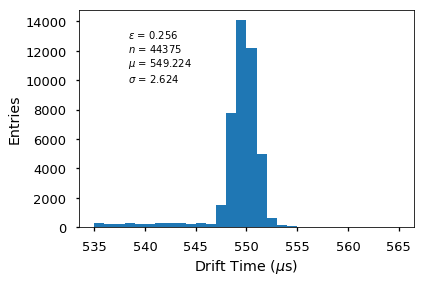

In [13]:
# Drift time histogram near the cathode region
y, x, _ = hst.hist(data.DT, 30, (minDriftTime, maxDriftTime), stats=optStat, xylabels=('Drift Time ($\mu$s)', 'Entries'));
# For the fit errors and fit chi2 to be correct, histogram errors on y need to be explicitly set
# Hack for now: fit results are not correct when some histogram error elements are zero, so add a small number there for now. To be fixed.  
ey = np.sqrt(y)
ey[np.where(ey==0)] = 1.e-1

In [14]:
# Fit the drift time histogram above with a gaussian
fitResult = fitf.fit(fitf.gauss, x, y, (5.e4, 550, 1), sigma=ey)
# Print the fit results
print(fitResult)

FitFunction(fn=<function fit.<locals>.<lambda> at 0x11878ab70>, values=array([  4.13271645e+04,   5.49802973e+02,   1.10686960e+00]), errors=array([  2.03290836e+02,   5.44583916e-03,   3.89371339e-03]), chi2=112.8827978436442, pvalue=0.0)


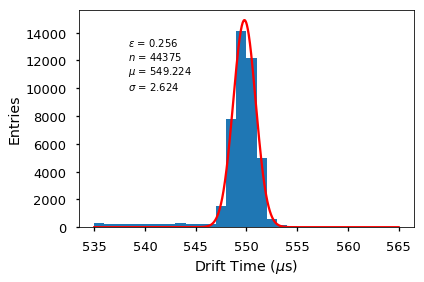

In [15]:
# Draw the drift time histogram with fit superimposed
hst.hist(data.DT, 30, (minDriftTime, maxDriftTime), stats=optStat, xylabels=('Drift Time ($\mu$s)', 'Entries'));
fitPoints = np.linspace(minDriftTime,maxDriftTime, 1000)
plt.plot(fitPoints, fitResult.fn(fitPoints), 'r')

In [16]:
# Grab fit results for gaussian peak position -> drift velocity
driftTime = fitResult.values[1]
# Conservative approach: take as error the gaussian width, as opposed to the fit error on the peak position
errDriftTime = fitResult.values[2]
cathodePos = 532 # mm
driftVelocity = cathodePos / driftTime
errDriftVelocity = cathodePos*errDriftTime / (driftTime*driftTime)
print('Drift time for cathode alphas: (%.2f +/- %.2f) us' %(driftTime, errDriftTime))
print('Drift velocity: (%.4f +/- %.4f) mm/us' %(driftVelocity, errDriftVelocity))

Drift time for cathode alphas: (549.80 +/- 1.11) us
Drift velocity: (0.9676 +/- 0.0019) mm/us


In [17]:
# Grab fit results for gaussian normalization -> fraction of cathode alphas
numCathodeAlphas = fitResult.values[0]
errNumCathodeAlphas = fitResult.errors[0]
fractionCathodeAlphas = numCathodeAlphas / numInclusiveAlphas
errFractionCathodeAlphas = errNumCathodeAlphas / numInclusiveAlphas
print('Number of cathode alphas: (%.1f +/- %.1f)' %(numCathodeAlphas, errNumCathodeAlphas))
print('Fraction of cathode alphas: (%.3f +/- %.3f)' %(fractionCathodeAlphas, errFractionCathodeAlphas))

Number of cathode alphas: (41327.2 +/- 203.3)
Fraction of cathode alphas: (0.238 +/- 0.001)
